In [49]:
# CELL 1 – Mount Drive & Link Correct Dataset
from google.colab import drive
drive.mount('/content/drive')

# Create symlinks to dataset
!ln -s "/content/drive/MyDrive/images" /content/images
!ln -s "/content/drive/MyDrive/annotations.json" /content/annotations.json

import os
print(f"Number of images: {len(os.listdir('/content/images'))}")
print(f"Sample names: {os.listdir('/content/images')[:5]}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/content/images/images': File exists
ln: failed to create symbolic link '/content/annotations.json': File exists
Number of images: 20002
Sample names: ['rendered_image_5424_mx.jpg', 'rendered_image_5449_mx.jpg', 'rendered_image_5446_mx.jpg', 'rendered_image_5454_mx.jpg', 'rendered_image_5456_mx.jpg']


In [50]:
# CELL 2 – Load + Fix Filenames & Class Labels (Critical Preprocessing)
import json, os

# Load annotations
with open('/content/annotations.json', 'r') as f:
    data = json.load(f)['annotations']

print(f"Total annotations: {len(data)}")

# Get real image filenames
real_images = set(os.listdir('/content/images'))

# Fix filenames
fixed = 0
for item in data:
    old = item['image']
    if old.startswith("image_"):
        num = old[6:10]
        mat = old[11] if len(old) >= 12 else 'm'
        new1 = f"rendered_image_{num}_{mat}.jpg"
        new2 = f"rendered_image_{num}_mx.jpg"
        if new1 in real_images:
            item['image'] = new1
            fixed += 1
        elif new2 in real_images:
            item['image'] = new2
            fixed += 1

# Normalize class labels
for item in data:
    label = item['class_label'].lower()
    if label in ['mix', 'mx', 'mixed']:
        item['class_label'] = 'mixed'

print(f"Fixed {fixed}/{len(data)} image names")

# Define class mapping
classes = ['glass', 'metal', 'mixed', 'plastic', 'wood']
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for i, c in enumerate(classes)}

print("Classes:", classes)

Total annotations: 20000
Fixed 14000/20000 image names
Classes: ['glass', 'metal', 'mixed', 'plastic', 'wood']


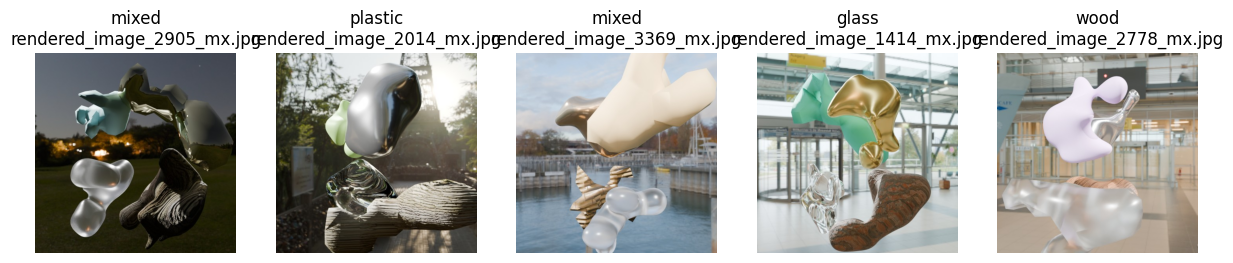

In [51]:
# CELL 3 – Show Sample Data
import random
import matplotlib.pyplot as plt
from PIL import Image

# Random sample
sample = random.sample(data, 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ax, item in zip(axes, sample):
    img_path = os.path.join('/content/images', item['image'])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"{item['class_label']}\n{item['image']}")
    ax.axis('off')

plt.show()

DATA CLEANING & VERIFICATION

1. CLASS DISTRIBUTION:
class_label
mixed      6000
metal      3500
glass      3500
plastic    3500
wood       3500
Name: count, dtype: int64
----------------------------------------

2. IMAGES WITHOUT ANNOTATIONS: 14002
ANNOTATIONS WITHOUT IMAGES: 0

3. CLEANING DATA...
Total annotations before cleaning: 20000
Total annotations after cleaning: 20000

4. CLEANED CLASS DISTRIBUTION:
class_label
mixed      6000
metal      3500
glass      3500
plastic    3500
wood       3500
Name: count, dtype: int64


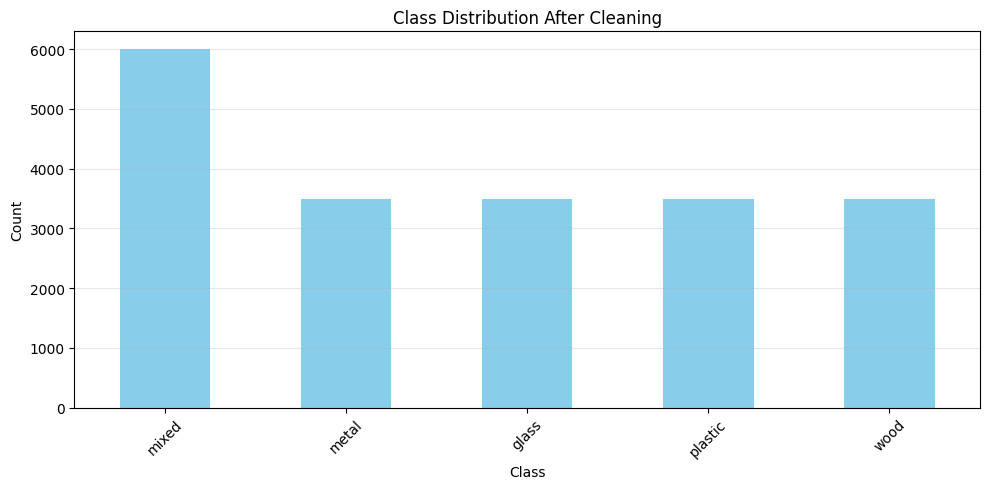


5. FINAL DATASET INFO:
Total images: 20002
Total annotations: 20000
Classes: ['mixed', 'metal', 'glass', 'plastic', 'wood']
Class counts: {'mixed': 6000, 'metal': 3500, 'glass': 3500, 'plastic': 3500, 'wood': 3500}


In [75]:
# CELL 4 – Data Cleaning & Verification (Post-Preprocessing)
import pandas as pd
import matplotlib.pyplot as plt

print("="*60)
print("DATA CLEANING & VERIFICATION")
print("="*60)

# Convert annotations to DataFrame for easier analysis
df = pd.DataFrame(data)

# 1. Check class distribution
print("\n1. CLASS DISTRIBUTION:")
print(df['class_label'].value_counts())
print("-"*40)

# 2. Find mismatches between images and annotations
fixed_images = set(df['image'])
real_images = set(os.listdir('/content/images'))

# Images without annotations
images_without_annots = real_images - fixed_images
print(f"\n2. IMAGES WITHOUT ANNOTATIONS: {len(images_without_annots)}")

# Annotations without corresponding images
annots_without_images = [img for img in df['image'] if img not in real_images]
print(f"ANNOTATIONS WITHOUT IMAGES: {len(annots_without_images)}")

if annots_without_images:
    print(f"Sample missing images: {annots_without_images[:5]}")

# 3. Remove annotations without images
print(f"\n3. CLEANING DATA...")
print(f"Total annotations before cleaning: {len(df)}")

# Remove rows where image doesn't exist
df_clean = df[df['image'].isin(real_images)].copy()
print(f"Total annotations after cleaning: {len(df_clean)}")

# 4. Check cleaned distribution
print(f"\n4. CLEANED CLASS DISTRIBUTION:")
class_dist = df_clean['class_label'].value_counts()
print(class_dist)

# Visualize distribution
plt.figure(figsize=(10, 5))
class_dist.plot(kind='bar', color='skyblue')
plt.title('Class Distribution After Cleaning')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Update data with cleaned version
data = df_clean.to_dict('records')

print(f"\n5. FINAL DATASET INFO:")
print(f"Total images: {len(real_images)}")
print(f"Total annotations: {len(data)}")
print(f"Classes: {list(class_dist.index)}")
print(f"Class counts: {class_dist.to_dict()}")
print("="*60)

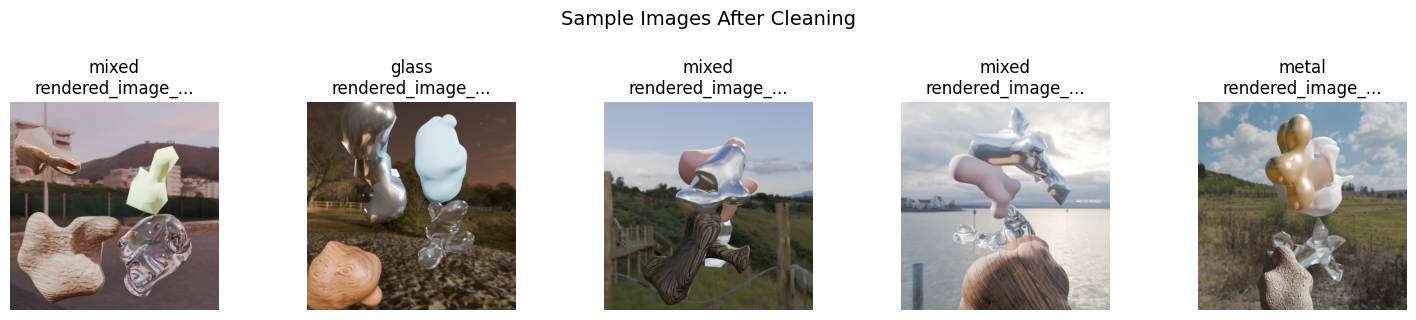

In [76]:
# CELL 5 – Show Sample Data After Cleaning
import random
import matplotlib.pyplot as plt
from PIL import Image

# Random sample from cleaned data
sample = random.sample(data, 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ax, item in zip(axes, sample):
    img_path = os.path.join('/content/images', item['image'])
    try:
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"{item['class_label']}\n{item['image'][:15]}...")
    except:
        ax.text(0.5, 0.5, 'Image not found',
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)
    ax.axis('off')

plt.suptitle('Sample Images After Cleaning', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

In [77]:
# CELL 6 – Create PyTorch DataLoader
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image

class MaterialDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = MaterialDataset(X_train, y_train, transform=train_transform)
val_dataset = MaterialDataset(X_val, y_val, transform=val_test_transform)
test_dataset = MaterialDataset(X_test, y_test, transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoaders created successfully.")

DataLoaders created successfully.


In [78]:
# CELL 7 – Advanced Augmentation using torchvision (WORKING VERSION)
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import random
import os

print("Setting up advanced augmentation pipeline using torchvision...")

def get_advanced_torchvision_augmentations():
    """تحويلات متقدمة لمحاكاة ظروف الإضاءة المختلفة"""
    return transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),

        # Lighting variations (BONUS FOCUS)
        transforms.ColorJitter(
            brightness=0.3,    # ±30% brightness variation
            contrast=0.3,      # ±30% contrast variation
            saturation=0.2,    # ±20% saturation
            hue=0.1           # ±10% hue
        ),

        # Advanced augmentations for texture robustness
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
        transforms.RandomAutocontrast(p=0.3),
        transforms.RandomGrayscale(p=0.1),

        # Simulate shadows and blur
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),

        # Convert to tensor
        transforms.ToTensor(),

        # Normalize (ImageNet stats)
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]),

        # Add simulated noise for industrial conditions
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.05),  # Gaussian noise
    ])

def get_basic_transform():

    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]),
    ])

# Dataset Class
class MaterialDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image if there's an error
            dummy_img = torch.zeros((3, 224, 224))
            return dummy_img, 0

# إنشاء التحويلات
train_transform_advanced = get_advanced_torchvision_augmentations()
val_transform = get_basic_transform()
test_transform = get_basic_transform()

# التحقق من البيانات
print(f"\nData info:")
print(f"X_train: {len(X_train)} samples")
print(f"X_val: {len(X_val)} samples")
print(f"X_test: {len(X_test)} samples")

# إنشاء Datasets
train_aug_dataset = MaterialDataset(X_train, y_train, transform=train_transform_advanced)
val_aug_dataset = MaterialDataset(X_val, y_val, transform=val_transform)
test_aug_dataset = MaterialDataset(X_test, y_test, transform=test_transform)

# إنشاء DataLoaders
train_aug_loader = DataLoader(train_aug_dataset, batch_size=32, shuffle=True, num_workers=2)
val_aug_loader = DataLoader(val_aug_dataset, batch_size=32, shuffle=False, num_workers=2)
test_aug_loader = DataLoader(test_aug_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"\n✓ Datasets created successfully!")
print(f"  Train dataset: {len(train_aug_dataset)} samples")
print(f"  Validation dataset: {len(val_aug_dataset)} samples")
print(f"  Test dataset: {len(test_aug_dataset)} samples")
print(f"  Classes: {classes}")

Setting up advanced augmentation pipeline using torchvision...

Data info:
X_train: 14000 samples
X_val: 3000 samples
X_test: 3000 samples

✓ Datasets created successfully!
  Train dataset: 14000 samples
  Validation dataset: 3000 samples
  Test dataset: 3000 samples
  Classes: ['glass', 'metal', 'mixed', 'plastic', 'wood']


 Lighting & Texture Augmentation

Visualizing 5 augmented samples...


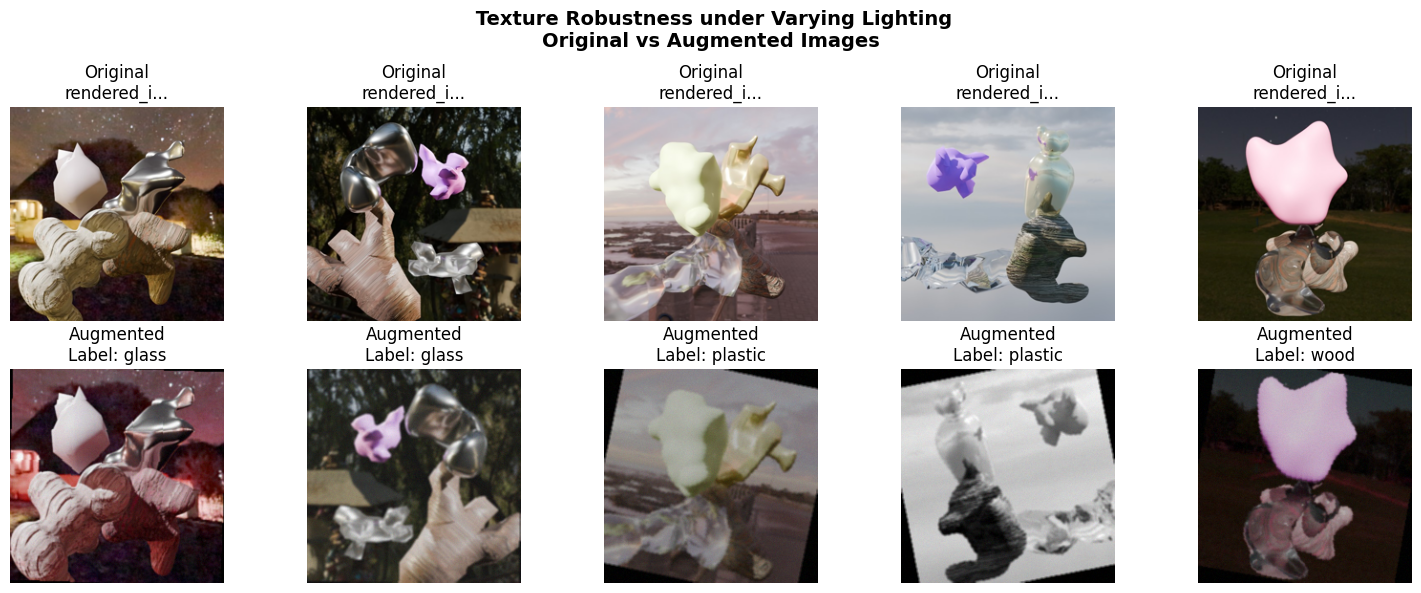

✓ Visualization completed!


In [73]:
# CELL 8 – Visualize Augmented Samples
import matplotlib.pyplot as plt

def visualize_augmentations(dataset, num_samples=5):

    print(f"\nVisualizing {num_samples} augmented samples...")


    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i, idx in enumerate(indices):

        img_path = dataset.image_paths[idx]
        try:

            orig_img = Image.open(img_path).convert('RGB')
            orig_img_resized = orig_img.resize((224, 224))

            axes[0, i].imshow(orig_img_resized)
            axes[0, i].set_title(f"Original\n{os.path.basename(img_path)[:10]}...")
            axes[0, i].axis('off')


            aug_img, label = dataset[idx]


            if isinstance(aug_img, torch.Tensor):

                if aug_img.shape[0] == 3:

                    img_display = aug_img.clone()


                    img_display = img_display.permute(1, 2, 0).cpu().numpy()
                    img_display = np.clip(
                        img_display * np.array([0.229, 0.224, 0.225]) +
                        np.array([0.485, 0.456, 0.406]),
                        0, 1
                    )
                else:
                    img_display = np.zeros((224, 224, 3))
            else:
                img_display = aug_img

            axes[1, i].imshow(img_display)
            axes[1, i].set_title(f"Augmented\nLabel: {idx_to_class[label]}")
            axes[1, i].axis('off')

        except Exception as e:
            print(f"  Error with sample {idx}: {e}")
            axes[0, i].text(0.5, 0.5, "Error", ha='center', va='center')
            axes[1, i].text(0.5, 0.5, "Error", ha='center', va='center')
            axes[0, i].axis('off')
            axes[1, i].axis('off')

    plt.suptitle(" Texture Robustness under Varying Lighting\nOriginal vs Augmented Images",
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("✓ Visualization completed!")

print("=" * 60)
print(" Lighting & Texture Augmentation")
print("=" * 60)

if 'train_aug_dataset' in locals() and len(train_aug_dataset) > 0:
    visualize_augmentations(train_aug_dataset, 5)
else:
    print("train_aug_dataset not found!")
    print("Please run Cell 6 first to create the dataset.")


    print("\nCreating emergency dataset...")
    train_aug_dataset = MaterialDataset(X_train[:50], y_train[:50], transform=train_transform_advanced)
    visualize_augmentations(train_aug_dataset, min(5, len(train_aug_dataset)))

In [79]:
# CELL 9 – Final Check: Class Distribution & DataLoader Test
import collections

# 1. Check class distribution in splits
def check_class_distribution(labels, split_name):
    print(f"\n{split_name} Class Distribution:")
    label_counts = collections.Counter(labels)
    for class_idx, count in label_counts.items():
        class_name = idx_to_class[class_idx]
        print(f"  {class_name}: {count} samples")
    print(f"  Total: {len(labels)} samples")

check_class_distribution(y_train, "TRAIN")
check_class_distribution(y_val, "VALIDATION")
check_class_distribution(y_test, "TEST")

# 2. Test DataLoader
print("\n" + "="*60)
print("Testing DataLoader...")
print("="*60)

try:
    # Get one batch
    for batch_idx, (images, labels) in enumerate(train_aug_loader):
        print(f"Batch {batch_idx+1}:")
        print(f"  Images shape: {images.shape}")  # Should be [32, 3, 224, 224]
        print(f"  Labels shape: {labels.shape}")  # Should be [32]
        print(f"  Labels: {labels[:5].tolist()}...")

        # Check normalization
        print(f"  Image range: [{images.min():.3f}, {images.max():.3f}]")
        print(f"  Mean: {images.mean():.3f}, Std: {images.std():.3f}")

        # Show first image stats
        if batch_idx == 0:
            img = images[0]
            print(f"\n  First image stats:")
            print(f"    Shape: {img.shape}")
            print(f"    Channel means: {img.mean(dim=(1,2)).tolist()}")
            print(f"    Channel stds: {img.std(dim=(1,2)).tolist()}")
        break
    print("\n✅ DataLoader is working correctly!")
except Exception as e:
    print(f"\n❌ Error in DataLoader: {e}")


TRAIN Class Distribution:
  wood: 2450 samples
  metal: 2450 samples
  mixed: 4200 samples
  plastic: 2450 samples
  glass: 2450 samples
  Total: 14000 samples

VALIDATION Class Distribution:
  mixed: 900 samples
  metal: 525 samples
  plastic: 525 samples
  glass: 525 samples
  wood: 525 samples
  Total: 3000 samples

TEST Class Distribution:
  plastic: 525 samples
  mixed: 900 samples
  wood: 525 samples
  metal: 525 samples
  glass: 525 samples
  Total: 3000 samples

Testing DataLoader...
Batch 1:
  Images shape: torch.Size([32, 3, 224, 224])
  Labels shape: torch.Size([32])
  Labels: [0, 3, 4, 2, 2]...
  Image range: [-2.340, 2.860]
  Mean: 0.074, Std: 1.261

  First image stats:
    Shape: torch.Size([3, 224, 224])
    Channel means: [0.33057859539985657, 0.37131866812705994, 0.45759275555610657]
    Channel stds: [1.0225847959518433, 1.1152968406677246, 1.2089054584503174]

✅ DataLoader is working correctly!
